<a href="https://colab.research.google.com/github/micah-shull/pipelines/blob/main/pipelines_09_class_imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Load & Preprocess Data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning)

# Define your parameters
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls"
categorical_columns = ['sex', 'education', 'marriage']
target = 'default_payment_next_month'


# Load and Preprocess Data
data = preprocess_data(url, categorical_columns)

# Check if data is loaded and preprocessed correctly
if data is not None:
    # Split the data
    X_train, X_test, y_train, y_test = split_data(data, target=target)

    # Define preprocessing steps for numerical and categorical columns
    numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

    # Create preprocessing pipeline
    pipeline = create_preprocessing_pipeline(numeric_features, categorical_features)
else:
    print("Data preprocessing failed. Please check the URL and preprocessing steps.")

Preprocessing pipeline created successfully.


### Class Imbalance

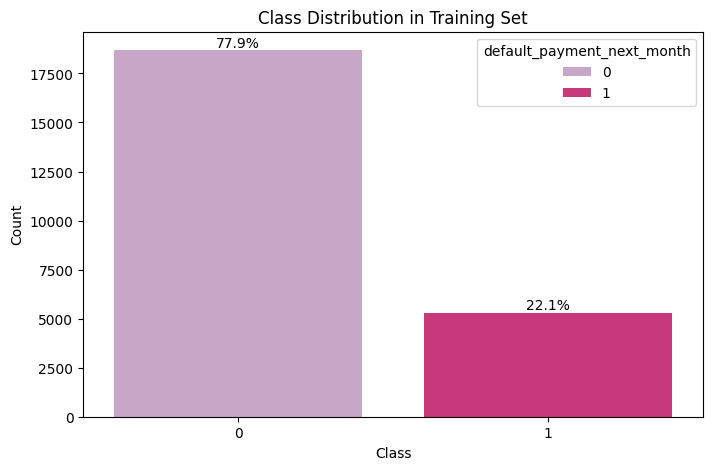

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot class balance in the training set with ratio annotations
def plot_class_distribution(y_train):
    plt.figure(figsize=(8, 5))
    sns.countplot(x=y_train, hue=y_train, palette='PuRd')
    plt.title('Class Distribution in Training Set')
    plt.xlabel('Class')
    plt.ylabel('Count')

    # Calculate the percentage for each class
    total = len(y_train)
    class_counts = y_train.value_counts()
    for i, count in enumerate(class_counts):
        percentage = 100 * count / total
        plt.text(i, count, f'{percentage:.1f}%', ha='center', va='bottom')

    plt.show()

plot_class_distribution(y_train)

In [ ]:
# Define the model
model = LogisticRegression(max_iter=500, random_state=42)

# Oversampling using SMOTE
smote = SMOTE(random_state=42)
pipeline_with_smote = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('smote', smote),
    ('model', model)
])

# Fit the pipeline with SMOTE
pipeline_with_smote.fit(X_train, y_train)

# Transform the test data and evaluate the model
evaluate_model(pipeline_with_smote, X_test, y_test)

# Undersampling using RandomUnderSampler
undersample = RandomUnderSampler(random_state=42)
pipeline_with_undersample = ImbPipeline(steps=[
    ('preprocessor', pipeline.named_steps['preprocessor']),
    ('undersample', undersample),
    ('model', model)
])

# Fit the pipeline with undersampling
pipeline_with_undersample.fit(X_train, y_train)

# Transform the test data and evaluate the model
evaluate_model(pipeline_with_undersample, X_test, y_test)

### Class Weights

In [ ]:
# Logistic Regression with class weights
model_with_weights = LogisticRegression(max_iter=500, class_weight='balanced', random_state=42)
pipeline_with_weights = add_model_to_pipeline(pipeline, model_with_weights)

# Fit the pipeline with class weights
pipeline_with_weights.fit(X_train, y_train)

# Transform the test data and evaluate the model
evaluate_model(pipeline_with_weights, X_test, y_test)


### Evaluation

In [ ]:
# Compare the performance of different methods
# You can store the results of each method and plot them for comparison

# Example: Logistic Regression without balancing
print("Logistic Regression without balancing")
evaluate_model(pipeline_with_model, X_test, y_test)

# Logistic Regression with SMOTE
print("Logistic Regression with SMOTE")
evaluate_model(pipeline_with_smote, X_test, y_test)

# Logistic Regression with undersampling
print("Logistic Regression with undersampling")
evaluate_model(pipeline_with_undersample, X_test, y_test)

# Logistic Regression with class weights
print("Logistic Regression with class weights")
evaluate_model(pipeline_with_weights, X_test, y_test)


### Write Data Utils Script

In [1]:
# function to write script
script_content = r'''

# data_utils.py

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV

# Load the dataset from a URL
def load_data_from_url(url):
    """
    Load the dataset from a specified URL.

    Parameters:
    - url: str, URL of the dataset

    Returns:
    - pd.DataFrame, loaded dataset
    """
    try:
        df = pd.read_excel(url, header=1)
    except Exception as e:
        print(f"Error loading data from URL: {e}")
        return None
    return df

# Clean column names
def clean_column_names(df):
    """
    Clean the column names by converting to lowercase and replacing spaces with underscores.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with cleaned column names
    """
    df.columns = [col.lower().replace(' ', '_') for col in df.columns]
    return df

# Remove the 'id' column
def remove_id_column(df):
    """
    Remove the 'id' column if it exists.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe without 'id' column
    """
    if 'id' in df.columns:
        df = df.drop(columns=['id'])
    return df

# Rename columns (pay_0 not in dataset)
def rename_columns(df):
    """
    Rename specific columns based on a predefined dictionary.

    Parameters:
    - df: pd.DataFrame, input dataframe

    Returns:
    - pd.DataFrame, dataframe with renamed columns
    """
    rename_dict = {
        'pay_0': 'pay_1'
    }
    df = df.rename(columns=rename_dict)
    return df

# Convert specified columns to categorical type
def convert_categorical(df, categorical_columns):
    """
    Convert specified columns to categorical type.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, dataframe with converted columns
    """
    df[categorical_columns] = df[categorical_columns].astype('category')
    return df

# Split the data into training and testing sets
def split_data(df, target):
    """
    Split the data into training and testing sets.

    Parameters:
    - df: pd.DataFrame, input dataframe
    - target: str, name of the target column

    Returns:
    - tuple, (X_train, X_test, y_train, y_test)
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test

def preprocess_data(url, categorical_columns):
    """
    Load and preprocess the data.

    Parameters:
    - url: str, URL of the dataset
    - categorical_columns: list of str, columns to convert to categorical type

    Returns:
    - pd.DataFrame, preprocessed data
    """
    # Load the dataset
    data = load_data_from_url(url)

    if data is None:
        return None

    # Clean column names
    data = clean_column_names(data)

    # Remove the 'id' column
    data = remove_id_column(data)

    # Rename columns
    data = rename_columns(data)

    # Convert specified columns to categorical type
    data = convert_categorical(data, categorical_columns)

    return data

def create_preprocessing_pipeline(numeric_features, categorical_features):
    """
    Create a preprocessing pipeline for numeric and categorical features.

    Parameters:
    - numeric_features: list of str, names of numeric features
    - categorical_features: list of str, names of categorical features

    Returns:
    - sklearn.pipeline.Pipeline, the complete preprocessing pipeline
    """
    # Define the transformers for numerical and categorical data
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine the transformers using ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)
        ]
    )

    # Create the full pipeline with preprocessing and a placeholder for the model
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor)
        # You can add your model here, e.g., ('model', RandomForestClassifier())
    ])

    print("Preprocessing pipeline created successfully.")
    return pipeline

def add_model_to_pipeline(pipeline, model):
    """
    Add a model to the preprocessing pipeline.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the preprocessing pipeline
    - model: sklearn estimator, the model to add to the pipeline

    Returns:
    - sklearn.pipeline.Pipeline, the complete pipeline with the model added
    """
    return Pipeline(steps=pipeline.steps + [('model', model)])

def evaluate_model(pipeline, X_test, y_test):
    """
    Evaluate the model using the test data.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - X_test: pd.DataFrame or np.ndarray, the test features
    - y_test: pd.Series or np.ndarray, the test labels

    Returns:
    - np.ndarray, the predicted labels
    """
    y_pred = pipeline.predict(X_test)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    # print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    return y_pred

def hyperparameter_tuning(pipeline, param_grid, X_train, y_train):
    """
    Perform hyperparameter tuning using GridSearchCV.

    Parameters:
    - pipeline: sklearn.pipeline.Pipeline, the complete pipeline with preprocessing and model
    - param_grid: dict, the parameter grid for GridSearchCV
    - X_train: pd.DataFrame or np.ndarray, the training features
    - y_train: pd.Series or np.ndarray, the training labels

    Returns:
    - sklearn estimator, the best estimator found by GridSearchCV
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print("Best Parameters:\n", grid_search.best_params_)
    return grid_search.best_estimator_

'''

# Write the script to a file
with open("data_utils.py", "w") as file:
    file.write(script_content)

print("Script successfully written to data_utils.py")

# reload script to make function available for use
import importlib
import data_utils
importlib.reload(data_utils)

from data_utils import (load_data_from_url, clean_column_names, remove_id_column,
                        rename_columns, convert_categorical, preprocess_data, split_data,
                        create_preprocessing_pipeline, add_model_to_pipeline, evaluate_model,
                        hyperparameter_tuning)

Script successfully written to data_utils.py
